## EELS - SpacMag



In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

Das Libra bietet 12 verschiedene SpecMag Werte, wobei diese in Absteigender Reihenfolge sortiert sind. Bei DM sind diese unter ``Filter:Zeiss Filter:Native dispersions`` zu finden. Zu jedem SpecMag Wert wird außerdem eine Kalibrierung hinterlegt. Diese sind in ``Filter:Calibrated dispersions:TEM:200000`` zu finden. Statt die Dispersion pro Pixel anzugeben, wird eine Variante gewählt, die die Pixel für ein Energieverlustintervall von 15 eV angibt. Es gilt somit:

DM-Dispersion[px] = 15eV / Dispersion[eV/px]

Die aktuell (am 7.9.2016) hinterlegten Werte sind in der nächsten IPython-Zelle aufgelistet und werden dort umgerechnet.

In [2]:
def convert_dispersion(dispersion):
    """Converts a dispersion from eV/px to the DM format and inversely.
    The calculation is the same for both directions."""
    return 15 / dispersion

dispersions_dm = {
    '315': 770.8,
    '250': 610,
    '200': 496.4,
    '163': 394.6,
    '125': 307.7,
    '100': 227.0,
    '80': 193.64,
    '63': 164.22,
    '50': 134.36,
    '40': 109.58,
    '19.5': 89.1,
    '0.25': 65.6
}

dispersions = {}
for key, value in dispersions_dm.items():
    dispersions[key] = convert_dispersion(value)

In [3]:
# Ich darf sort() anwenden, da die erste Liste monoton absteigende
# und die zweite Liste monoton aufsteigende Werte enthält.
# Im Dictionary waren die Werte nicht sortiert.
spec_mags = [float(sm) for sm in dispersions.keys()]
spec_mags.sort(reverse=True)
cam_width = 4096
spec_width = [cam_width * value for value in dispersions.values()]
spec_width.sort()

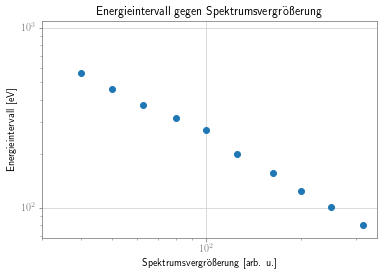

In [4]:
plt.title('Energieintervall gegen Spektrumsvergrößerung')
plt.xlabel('Spektrumsvergrößerung [arb. u.]')
plt.ylabel('Energieintervall [eV]')
plt.xlim(30,350)
plt.yscale('log')
plt.xscale('log')
plt.scatter(spec_mags, spec_width)
plt.show()

In [5]:
# http://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html
import scipy.optimize

power_func = lambda x,a,r: a*x**r
exp_func = lambda x,a,c: a*np.exp(-c*x)
errfunc = lambda p,x,y: (y-power_func(x,p[0],p[1]))
errfunc2 = lambda p,x,y: (y-exp_func(x,p[0],p[1]))
# http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html#scipy.optimize.least_squares
# Alternative:
# http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html#scipy.optimize.curve_fit
p, cov_p, info, mesg, success = scipy.optimize.leastsq(
    errfunc, [1000,-1], args=(spec_mags[:-2], spec_width[:-2]), full_output=True)
if success:
    print('Potenzfunktion:')
    print(p)
    print(cov_p)
else:
    print(mesg)

popt, pcov = scipy.optimize.curve_fit(exp_func, spec_mags[:-2], spec_width[:-2], p0=(1, 1e-6))
print('Exponentialfunktion:')
print(popt)

Potenzfunktion:
[  1.54580213e+04  -8.97097502e-01]
[[  2.00159901e+04  -3.11895009e-01]
 [ -3.11895009e-01   4.92307624e-06]]
Exponentialfunktion:
[  7.54876015e+02   9.82800982e-03]


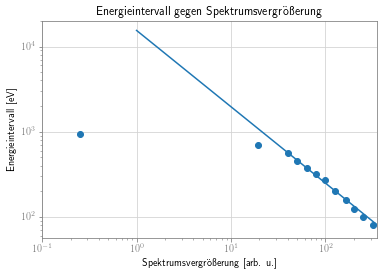

In [6]:
plt.title('Energieintervall gegen Spektrumsvergrößerung')
plt.xlabel('Spektrumsvergrößerung [arb. u.]')
plt.ylabel('Energieintervall [eV]')
plt.xlim(0.1,350)
plt.yscale('log')
plt.xscale('log')
plt.plot(range(1,350),power_func(range(1,350), p[0], p[1]))
plt.scatter(spec_mags, spec_width)
plt.show()

In [7]:
import math

solve_func = lambda x,t: t - power_func(x, p[0], p[1])

width1 = dispersions['19.5'] * cam_width
width2 = dispersions['0.25'] * cam_width

sm1 = scipy.optimize.fsolve(solve_func, 19.5, width1)[0]
sm2 = scipy.optimize.fsolve(solve_func, 0.25, width2)[0]

print(sm1, sm2)

32.0258099965 22.7652987107


In [8]:
if 19.5 in spec_mags:
    spec_mags[spec_mags.index(19.5)] = round(sm1/5)*5
if 0.25 in spec_mags:
    spec_mags[spec_mags.index(0.25)] = round(sm2/5)*5
print(spec_mags)

[315.0, 250.0, 200.0, 163.0, 125.0, 100.0, 80.0, 63.0, 50.0, 40.0, 30.0, 25.0]


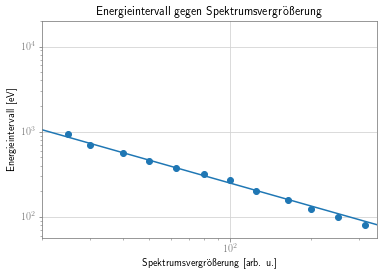

In [9]:
plt.title('Energieintervall gegen Spektrumsvergrößerung')
plt.xlabel('Spektrumsvergrößerung [arb. u.]')
plt.ylabel('Energieintervall [eV]')
plt.xlim(20,350)
plt.yscale('log')
plt.xscale('log')
plt.plot(range(1,350),power_func(range(1,350), p[0], p[1]))
plt.scatter(spec_mags, spec_width)
plt.show()

Die Auswertung hat gezeigt, dass die beiden kleinsten Werte angepasst werden müssen. Aus 19,5 wird 30 und aus 0,25 wird 25. Dies setzt jedoch vorraus, dass die hinterlegten Dispersionen korrekt sind. Ist dies nicht der Fall, dann ergeben sich abweichende Werte.

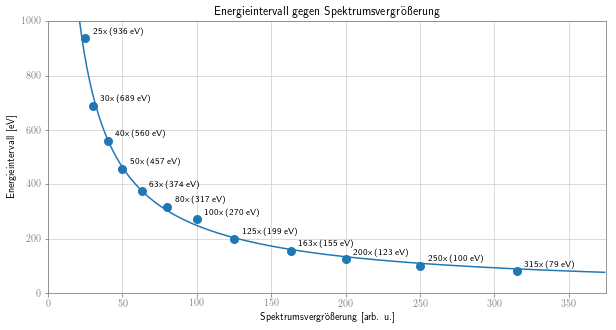

In [10]:
plt.figure(figsize=(10, 5))
plt.title('Energieintervall gegen Spektrumsvergrößerung')
plt.xlabel('Spektrumsvergrößerung [arb. u.]')
plt.ylabel('Energieintervall [eV]')
plt.plot(range(1,375), power_func(range(1,375), p[0], p[1]))
#plt.plot(range(1,375), exp_func(range(1,375), popt[0], popt[1]))
plt.scatter(spec_mags, spec_width, linewidths=3, )
plt.xlim(0, 375)
plt.ylim(0, 1000)
for i, mag in enumerate(spec_mags):
    plt.text(mag + 5,
             spec_width[i] + 10,
             '%dx (%d eV)' % (int(mag), spec_width[i]),
             verticalalignment='bottom',
             horizontalalignment='left',
             fontsize=9
            )
plt.savefig('Bilder/Intervall_vs_SpecMag')
plt.show()

In [11]:
sm_list = [(float(key), dispersions[key]) for key in dispersions.keys()]

print('SM\tDispersion')
for sm in sorted(sm_list, key=lambda x: x[0]):
    print('%s:\t%g' % sm)

SM	Dispersion
0.25:	0.228659
19.5:	0.16835
40.0:	0.136886
50.0:	0.11164
63.0:	0.0913409
80.0:	0.0774633
100.0:	0.0660793
125.0:	0.0487488
163.0:	0.0380132
200.0:	0.0302176
250.0:	0.0245902
315.0:	0.0194603
